In [3]:
import pandas as pd
# ——————————————————————————————————————————
# 1) Φόρτωσε τα δεδομένα
# ——————————————————————————————————————————
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")

print(df.columns)

Index(['citing', 'cited', 'label', 'split', 'tfidf_similarity',
       'specter_similarity', 'same_bertopic', 'sum_bertopic_entropy',
       'bertopic_topic_cosine', 'author_overlap', 'jaccard_authors',
       'author_mean_pagerank_citing', 'author_mean_pagerank_cited',
       'author_max_pagerank_citing', 'author_max_pagerank_cited',
       'author_mean_degree_citing', 'author_mean_degree_cited', '(S) Degree',
       '(D) Degree', '(S) Avg neigh deg', '(D) Avg neigh deg', '(S) Triangles',
       '(D) Triangles', '(S) Core number', '(D) Core number',
       '(S) Eig centrality', '(D) Eig centrality', '(S) Clustering',
       '(D) Clustering', '(S) Greedy color', '(D) Greedy color',
       '(S) Onion number', '(D) Onion number', 'Jaccard Coefficient',
       'Salton index', 'Hub Depressed Index', 'Academic Adar Index',
       'Pref Attachment', 'Ressource Allocation Index', 'Shortest Path',
       'author_common_neighbors', 'author_adamic_adar',
       'author_resource_allocation', 'cit

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# ——————————————————————————————————————————
# 1) Φόρτωσε τα δεδομένα
# ——————————————————————————————————————————
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split"]
X = df.drop(columns=meta_cols)

# ——————————————————————————————————————————
# 2) Προεπεξεργασία: Standard scaling όλων των numeric features
# ——————————————————————————————————————————
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

# ——————————————————————————————————————————
# 3) Στήσιμο pipelines για LR, XGB, MLP
# ——————————————————————————————————————————
pipelines = {
    "lr": Pipeline([("prep", preprocessor),
                    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))]),
    "xgb": Pipeline([("prep", preprocessor),
                     ("clf", XGBClassifier(eval_metric="logloss", n_jobs=8))]),
    "mlp": Pipeline([("prep", preprocessor),
                     ("clf", MLPClassifier(hidden_layer_sizes=(256,128,64),
                                           max_iter=200,
                                           early_stopping=True))]),
}

# ——————————————————————————————————————————
# 4) Train/Test split
# ——————————————————————————————————————————
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ——————————————————————————————————————————
# 5) Εκπαίδευση & Βασική αξιολόγηση (με ROC AUC & Log Loss)
# ——————————————————————————————————————————
for name, pipe in pipelines.items():
    print(f"\n--- Training {name} ---")
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC:  {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Log loss: {log_loss(y_test, y_proba):.4f}")

# ——————————————————————————————————————————
# 6) Cross‐validation για το LR (ROC AUC)
# ——————————————————————————————————————————
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    pipelines["lr"], X, y,
    cv=skf,
    scoring="roc_auc",
    n_jobs=-1
)
print("\nLR 5‐fold CV ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC:", cv_scores.mean())

# ——————————————————————————————————————————
# 7) Hyperparameter tuning με GridSearchCV
# ——————————————————————————————————————————
param_grids = {
    "lr":  { "clf__C":            [0.01, 0.1, 1, 10] },
    "xgb": { "clf__learning_rate":[0.01, 0.1, 0.2],
             "clf__max_depth":     [3, 5, 7] },
    "mlp": { "clf__alpha":        [1e-4, 1e-3, 1e-2],
             "clf__hidden_layer_sizes": [(100,),(100,50),(200,100)] }
}

grids = {}
for name in ["lr","xgb","mlp"]:
    print(f"\n>>> GridSearchCV for {name}")
    grid = GridSearchCV(
        pipelines[name],
        param_grid=param_grids[name],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best CV ROC AUC:", grid.best_score_)
    # αποθήκευση του καλύτερου μοντέλου
    grids[name] = grid.best_estimator_

# ——————————————————————————————————————————
# 8) Τελική αξιολόγηση των καλύτερων μοντέλων (με ROC AUC & Log Loss)
# ——————————————————————————————————————————
for name, model in grids.items():
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n*** Final eval {name} ***")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC:  {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Log loss: {log_loss(y_test, y_proba):.4f}")



--- Training lr ---
              precision    recall  f1-score   support

           0     0.9874    0.9884    0.9879    218391
           1     0.9884    0.9874    0.9879    218391

    accuracy                         0.9879    436782
   macro avg     0.9879    0.9879    0.9879    436782
weighted avg     0.9879    0.9879    0.9879    436782

ROC AUC:  0.9985
Log loss: 0.0402

--- Training xgb ---
              precision    recall  f1-score   support

           0     0.9910    0.9943    0.9926    218391
           1     0.9943    0.9910    0.9926    218391

    accuracy                         0.9926    436782
   macro avg     0.9926    0.9926    0.9926    436782
weighted avg     0.9926    0.9926    0.9926    436782

ROC AUC:  0.9996
Log loss: 0.0217

--- Training mlp ---


D:\NLP\gnn_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


              precision    recall  f1-score   support

           0     0.9907    0.9937    0.9922    218391
           1     0.9936    0.9906    0.9921    218391

    accuracy                         0.9921    436782
   macro avg     0.9922    0.9921    0.9921    436782
weighted avg     0.9922    0.9921    0.9921    436782

ROC AUC:  0.9995
Log loss: 0.0239


In [2]:
# K-Fold Cross Validation for Logistic Regression
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# ——————————————————————————————————————————
# 1) Φόρτωσε τα δεδομένα
# ——————————————————————————————————————————
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split", "Shortest Path"]
X = df.drop(columns=meta_cols)

# ——————————————————————————————————————————
# 2) Προεπεξεργασία: Standard scaling όλων των numeric features
# ——————————————————————————————————————————
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

# ——————————————————————————————————————————
# 3) Pipeline μόνο για Logistic Regression
# ——————————————————————————————————————————
pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

# ——————————————————————————————————————————
# 4) Cross‐validation setup
# ——————————————————————————————————————————
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ——————————————————————————————————————————
# 5) Εκτέλεση cross‐validation με train & test scores
# ——————————————————————————————————————————
scoring = {
    "roc_auc":        "roc_auc",
    "neg_log_loss":   "neg_log_loss"
}

cv_results = cross_validate(
    pipe_lr,
    X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=1,
    verbose=1
)

# ——————————————————————————————————————————
# 6) Εκτύπωση των αποτελεσμάτων
# ——————————————————————————————————————————
for split in range(cv_results["fit_time"].shape[0]):
    print(f"Fold {split+1}")
    print(f"  Train ROC AUC:      {cv_results['train_roc_auc'][split]:.4f}")
    print(f"  Test  ROC AUC:      {cv_results['test_roc_auc'][split]:.4f}")
    # flip sign of neg_log_loss to get positive log‐loss
    print(f"  Train Log Loss:     {-cv_results['train_neg_log_loss'][split]:.4f}")
    print(f"  Test  Log Loss:     {-cv_results['test_neg_log_loss'][split]:.4f}")
    print()

print("Mean across folds:")
print(f"  Train ROC AUC:      {cv_results['train_roc_auc'].mean():.4f}")
print(f"  Test  ROC AUC:      {cv_results['test_roc_auc'].mean():.4f}")
print(f"  Train Log Loss:     {-cv_results['train_neg_log_loss'].mean():.4f}")
print(f"  Test  Log Loss:     {-cv_results['test_neg_log_loss'].mean():.4f}")


Fold 1
  Train ROC AUC:      0.9971
  Test  ROC AUC:      0.9969
  Train Log Loss:     0.0595
  Test  Log Loss:     0.0609

Fold 2
  Train ROC AUC:      0.9970
  Test  ROC AUC:      0.9971
  Train Log Loss:     0.0600
  Test  Log Loss:     0.0589

Fold 3
  Train ROC AUC:      0.9971
  Test  ROC AUC:      0.9971
  Train Log Loss:     0.0599
  Test  Log Loss:     0.0595

Fold 4
  Train ROC AUC:      0.9971
  Test  ROC AUC:      0.9971
  Train Log Loss:     0.0598
  Test  Log Loss:     0.0597

Fold 5
  Train ROC AUC:      0.9971
  Test  ROC AUC:      0.9970
  Train Log Loss:     0.0597
  Test  Log Loss:     0.0601

Mean across folds:
  Train ROC AUC:      0.9971
  Test  ROC AUC:      0.9971
  Train Log Loss:     0.0598
  Test  Log Loss:     0.0598


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


In [ ]:
# Sanity Check 

In [8]:
# Ανάγνωση του αρχείου test.txt που έχει γραμμές της μορφής "0,1"
test_df_edgelist = pd.read_csv(
    r"C:\Users\mysmu\Desktop\Natural Language Processing\nlp-cse-uoi-2025\data_new\test.txt",
    sep=",",
    header=None,
    names=["citing", "cited"],
    dtype={"citing": int, "cited": int}
)
# ——————————————————————————————————————————
# 2) Εξαγωγή μοναδικών κόμβων από citing & cited
# ——————————————————————————————————————————
train_nodes = set(df["citing"]).union(df["cited"])
test_nodes  = set(test_df_edgelist["citing"]) .union(test_df_edgelist["cited"])

# ——————————————————————————————————————————
# 3) Υπολογισμός κοινών vs. άγνωστων κόμβων
# ——————————————————————————————————————————
common_nodes = test_nodes.intersection(train_nodes)
new_nodes    = test_nodes.difference(train_nodes)

print(f"Συνολικοί κόμβοι στο test:      {len(test_nodes)}")
print(f"Κοινώς εμφανιζόμενοι στο train:  {len(common_nodes)}")
print(f"Άγνωστοι κόμβοι στο test:       {len(new_nodes)}")

# ——————————————————————————————————————————
# 4) Δείγματα άγνωστων κόμβων
# ——————————————————————————————————————————
print("Πρώτα 20 άγνωστα node IDs:", list(new_nodes)[:20])


Συνολικοί κόμβοι στο test:      99760
Κοινώς εμφανιζόμενοι στο train:  99760
Άγνωστοι κόμβοι στο test:       0
Πρώτα 20 άγνωστα node IDs: []


In [ ]:
# Sanity Check 2

In [11]:
import pandas as pd

# ——————————————————————————————————————————
# 1) Φόρτωσε train & test data
# ——————————————————————————————————————————
# Train με features + meta_cols (χρειαζόμαστε μόνο τα citing/cited)
train_df         = pd.read_parquet(r"D:/NLP/tfidf_xgboost/data_full.parquet")
train_edges      = train_df[["citing", "cited"]].drop_duplicates()
train_edge_set   = set(zip(train_edges["citing"], train_edges["cited"]))

# Test edge‐list (citing–cited pairs)
test_df_edgelist = pd.read_csv(
    r"C:\Users\mysmu\Desktop\Natural Language Processing\nlp-cse-uoi-2025\data_new\test.txt",
    sep=",", header=None,
    names=["citing", "cited"],
    dtype={"citing": int, "cited": int}
)

# Test features (χωρίς citing/cited)
test_df_feats    = pd.read_parquet(r"D:\NLP\data\test_features.parquet")

# ——————————————————————————————————————————
# 2) Επαναφορά index για σωστό concatenate
# ——————————————————————————————————————————
test_df_edgelist = test_df_edgelist.reset_index(drop=True)
test_df_feats    = test_df_feats.reset_index(drop=True)

# ——————————————————————————————————————————
# 3) Ένωση edge‐list με τα features βάσει θέσης
# ——————————————————————————————————————————
test_merged = pd.concat([test_df_edgelist, test_df_feats], axis=1)
print(f"Merged test shape: {test_merged.shape}")

# ——————————————————————————————————————————
# 4) Έλεγχος για ζεύγη που ήδη υπάρχουν στο train
# ——————————————————————————————————————————
# Προσθέτουμε boolean flag 'in_train'
test_merged["in_train"] = test_merged.apply(
    lambda row: (row["citing"], row["cited"]) in train_edge_set,
    axis=1
)

# Πόσα κοινά vs νέα ζεύγη
n_total  = len(test_merged)
n_common = test_merged["in_train"].sum()
n_new    = n_total - n_common

print(f"Συνολικές εγγραφές στο test:      {n_total}")
print(f"Υπάρχουν ήδη στο train:          {n_common}")
print(f"Νέα (μόνο στο test):             {n_new}")



Merged test shape: (106692, 67)
Συνολικές εγγραφές στο test:      106692
Υπάρχουν ήδη στο train:          7
Νέα (μόνο στο test):             106685


In [4]:
test_df_feats = pd.read_parquet(r"D:\NLP\data\test_features.parquet")
print(test_df_feats.columns)

Index(['tfidf_similarity', 'specter_similarity', 'same_bertopic',
       'sum_bertopic_entropy', 'bertopic_topic_cosine', 'author_overlap',
       'jaccard_authors', 'author_mean_pagerank_citing',
       'author_mean_pagerank_cited', 'author_max_pagerank_citing',
       'author_max_pagerank_cited', 'author_mean_degree_citing',
       'author_mean_degree_cited', '(S) Degree', '(D) Degree',
       '(S) Avg neigh deg', '(D) Avg neigh deg', '(S) Triangles',
       '(D) Triangles', '(S) Core number', '(D) Core number',
       '(S) Eig centrality', '(D) Eig centrality', '(S) Clustering',
       '(D) Clustering', '(S) Greedy color', '(D) Greedy color',
       '(S) Onion number', '(D) Onion number', 'Jaccard Coefficient',
       'Salton index', 'Hub Depressed Index', 'Academic Adar Index',
       'Pref Attachment', 'Ressource Allocation Index', 'Shortest Path',
       'author_common_neighbors', 'author_adamic_adar',
       'author_resource_allocation', 'citation_node2vec_cosine',
       'citat

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# ——————————————————————————————————————————
# 1) Φόρτωσε τα train δεδομένα
# ——————————————————————————————————————————
train_df = pd.read_parquet(r"D:/NLP/tfidf_xgboost/data_full.parquet")
y = train_df["label"]
meta_cols = ["citing", "cited", "label", "split", "Shortest Path"]
X = train_df.drop(columns=meta_cols)

# ——————————————————————————————————————————
# 2) Ορισμός preprocessor + pipeline για LR
# ——————————————————————————————————————————
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

# ——————————————————————————————————————————
# 3) Εκπαίδευση του μοντέλου σε όλο το train set
# ——————————————————————————————————————————
pipe_lr.fit(X, y)

# ——————————————————————————————————————————
# 4) Φόρτωσε τα unseen test ζεύγη και features
# ——————————————————————————————————————————
# edge‐list με citing/cited pairs
test_edges = pd.read_csv(
    r"C:\Users\mysmu\Desktop\Natural Language Processing\nlp-cse-uoi-2025\data_new\test.txt",
    sep=",", header=None,
    names=["citing", "cited"],
    dtype={"citing": int, "cited": int}
).reset_index(drop=True)

# test features (χωρίς label)
test_feats = pd.read_parquet(r"D:\NLP\data\test_features.parquet").reset_index(drop=True)

# ——————————————————————————————————————————
# 5) Ένωση edge‐list & features
# ——————————————————————————————————————————
test_merged = pd.concat([test_edges, test_feats], axis=1)

# ——————————————————————————————————————————
# 6) Προετοιμασία X_test (κρατάμε μόνο numeric features)
# ——————————————————————————————————————————
X_test = test_merged.drop(columns=["citing", "cited", "Shortest Path"])

# ——————————————————————————————————————————
# 7) Πρόβλεψη πιθανοτήτων (κλάση “1”)
# ——————————————————————————————————————————
y_proba = pipe_lr.predict_proba(X_test)[:, 1]

# ——————————————————————————————————————————
# 8) Δημιουργία submission DataFrame & αποθήκευση
# ——————————————————————————————————————————
submission = pd.DataFrame({
    "ID":    range(len(y_proba)),
    "Label": y_proba
})

submission.to_csv("submission_fixed.csv", index=False)
print(submission.head())


   ID     Label
0   0  0.780903
1   1  0.000873
2   2  0.552140
3   3  0.940749
4   4  0.000267


In [20]:
import pandas as pd
from sklearn.compose        import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import Pipeline
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics       import log_loss, roc_auc_score

# 1) φόρτωσε
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
meta_cols = ["citing","cited","label","split","Shortest Path"]
X_all     = df.drop(columns=meta_cols)
y_all     = df["label"]

# 2) διάκριση train/test
df_tr = df[df["split"]=="train"]
df_te = df[df["split"]=="val"]

X_tr = df_tr.drop(columns=meta_cols)
y_tr = df_tr["label"]
X_te = df_te.drop(columns=meta_cols)
y_te = df_te["label"]

# 3) pipeline
numeric_feats = X_tr.columns.tolist()
prep = ColumnTransformer([("num", StandardScaler(), numeric_feats)])
pipe = Pipeline([("prep", prep),
                 ("clf", LogisticRegression(max_iter=1000, n_jobs=1))])

# 4) εκπαίδευση & αξιολόγηση στο πραγματικό hold-out
pipe.fit(X_tr, y_tr)
proba_te = pipe.predict_proba(X_te)[:,1]
print("Hold-out ROC AUC:  ", roc_auc_score(y_te, proba_te))
print("Hold-out Log-loss:", log_loss(y_te, proba_te))


Hold-out ROC AUC:   0.9796982050445089
Hold-out Log-loss: 0.23457609332621784


In [17]:
import pandas as pd

df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
print(df["split"].value_counts())


train    1965519
val       218391
Name: split, dtype: int64


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# ——————————————————————————————————————————
# 1) Φόρτωσε τα δεδομένα
# ——————————————————————————————————————————
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split"]
X = df.drop(columns=meta_cols)

# ——————————————————————————————————————————
# 2) Προεπεξεργασία: Standard scaling όλων των numeric features
# ——————————————————————————————————————————
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

# ——————————————————————————————————————————
# 3) Στήσιμο pipelines για LR, XGB, MLP
# ——————————————————————————————————————————
pipelines = {
    "lr": Pipeline([("prep", preprocessor),
                    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))]),
    "xgb": Pipeline([("prep", preprocessor),
                     ("clf", XGBClassifier(eval_metric="logloss", n_jobs=8))]),
    "mlp": Pipeline([("prep", preprocessor),
                     ("clf", MLPClassifier(hidden_layer_sizes=(100,50),
                                           max_iter=200,
                                           early_stopping=True))]),
}

# ——————————————————————————————————————————
# 4) Train/Test split
# ——————————————————————————————————————————
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ——————————————————————————————————————————
# 5) Εκπαίδευση & Βασική αξιολόγηση
# ——————————————————————————————————————————
for name, pipe in pipelines.items():
    print(f"\n--- Training {name} ---")
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# ——————————————————————————————————————————
# 6) Cross‐validation για το LR
# ——————————————————————————————————————————
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipelines["lr"], X, y,
                            cv=skf, scoring="roc_auc", n_jobs=-1)
print("\nLR 5-fold CV ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC:", cv_scores.mean())

# ——————————————————————————————————————————
# 7) Hyperparameter tuning με GridSearchCV
# ——————————————————————————————————————————
param_grids = {
    "lr":  { "clf__C":            [0.01, 0.1, 1, 10] },
    "xgb": { "clf__learning_rate":[0.01, 0.1, 0.2],
             "clf__max_depth":     [3, 5, 7] },
    "mlp": { "clf__alpha":        [1e-4, 1e-3, 1e-2],
             "clf__hidden_layer_sizes": [(100,),(100,50),(200,100)] }
}

grids = {}
for name in ["lr","xgb","mlp"]:
    print(f"\n>>> GridSearchCV for {name}")
    grid = GridSearchCV(
        pipelines[name],
        param_grid=param_grids[name],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best CV ROC AUC:", grid.best_score_)
    # αποθήκευση του καλύτερου μοντέλου
    grids[name] = grid.best_estimator_

# ——————————————————————————————————————————
# 8) Τελική αξιολόγηση των καλύτερων μοντέλων
# ——————————————————————————————————————————
for name, model in grids.items():
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n*** Final eval {name} ***")
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")



--- Training lr ---
              precision    recall  f1-score   support

           0     0.9874    0.9884    0.9879    218391
           1     0.9884    0.9874    0.9879    218391

    accuracy                         0.9879    436782
   macro avg     0.9879    0.9879    0.9879    436782
weighted avg     0.9879    0.9879    0.9879    436782

ROC AUC: 0.9985

--- Training xgb ---
              precision    recall  f1-score   support

           0     0.9910    0.9943    0.9926    218391
           1     0.9943    0.9910    0.9926    218391

    accuracy                         0.9926    436782
   macro avg     0.9926    0.9926    0.9926    436782
weighted avg     0.9926    0.9926    0.9926    436782

ROC AUC: 0.9996

--- Training mlp ---
              precision    recall  f1-score   support

           0     0.9906    0.9935    0.9921    218391
           1     0.9935    0.9906    0.9920    218391

    accuracy                         0.9920    436782
   macro avg     0.9920    0.99

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1) Φόρτωσε τα δεδομένα
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split"]
X = df.drop(columns=meta_cols)

# 2) Preprocessing: Standard scaling
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

# 3) Pipelines για LR, XGB, MLP
pipelines = {
    "lr": Pipeline([("prep", preprocessor),
                    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))]),
    "xgb": Pipeline([("prep", preprocessor),
                     ("clf", XGBClassifier(eval_metric="logloss", n_jobs=8))]),
    "mlp": Pipeline([("prep", preprocessor),
                     ("clf", MLPClassifier(hidden_layer_sizes=(100,50),
                                           max_iter=200,
                                           early_stopping=True))]),
}

# 4) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 5) Εκπαίδευση & Βασική αξιολόγηση με AUC + Log Loss + παράμετροι
for name, pipe in pipelines.items():
    print(f"\n--- Training {name} ---")
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    
    # Εκτύπωση classification report
    print(classification_report(y_test, y_pred, digits=4))
    
    # ROC AUC
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.4f}")
    
    # Log Loss
    ll = log_loss(y_test, y_proba)
    print(f"Log Loss: {ll:.4f}")
    
    # Παράμετροι μοντέλου
    clf = pipe.named_steps["clf"]
    print("Model parameters:")
    for param, val in clf.get_params().items():
        print(f"  {param}: {val}")

# 6) 5-fold CV για το LR (όπως έχεις ήδη)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipelines["lr"], X, y,
                            cv=skf, scoring="roc_auc", n_jobs=-1)
print("\nLR 5-fold CV ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC:", cv_scores.mean())

# 7) GridSearchCV για hyperparameter tuning
param_grids = {
    "lr":  { "clf__C":            [0.01, 0.1, 1, 10] },
    "xgb": { "clf__learning_rate":[0.01, 0.1, 0.2],
             "clf__max_depth":     [3, 5, 7] },
    "mlp": { "clf__alpha":        [1e-4, 1e-3, 1e-2],
             "clf__hidden_layer_sizes": [(100,),(100,50),(200,100)] }
}

grids = {}
for name in ["lr","xgb","mlp"]:
    print(f"\n>>> GridSearchCV for {name}")
    grid = GridSearchCV(
        pipelines[name],
        param_grid=param_grids[name],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best CV ROC AUC:", grid.best_score_)
    grids[name] = grid.best_estimator_

# 8) Τελική αξιολόγηση των καλύτερων μοντέλων με Log Loss + AUC + classification report
for name, model in grids.items():
    print(f"\n*** Final eval {name} ***")
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(classification_report(y_test, y_pred, digits=4))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Log Loss: {log_loss(y_test, y_proba):.4f}")
    print("Trained model parameters:")
    for param, val in model.named_steps["clf"].get_params().items():
        print(f"  {param}: {val}")



--- Training lr ---
              precision    recall  f1-score   support

           0     0.9874    0.9884    0.9879    218391
           1     0.9884    0.9874    0.9879    218391

    accuracy                         0.9879    436782
   macro avg     0.9879    0.9879    0.9879    436782
weighted avg     0.9879    0.9879    0.9879    436782

ROC AUC: 0.9985
Log Loss: 0.0402
Model parameters:
  C: 1.0
  class_weight: None
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: deprecated
  n_jobs: -1
  penalty: l2
  random_state: None
  solver: lbfgs
  tol: 0.0001
  verbose: 0
  warm_start: False

--- Training xgb ---
              precision    recall  f1-score   support

           0     0.9910    0.9943    0.9926    218391
           1     0.9943    0.9910    0.9926    218391

    accuracy                         0.9926    436782
   macro avg     0.9926    0.9926    0.9926    436782
weighted avg     0.9926    0.9926    0.9926    

In [11]:
import pandas as pd
from xgboost import XGBClassifier

# 1. Φόρτωση train/val δεδομένων
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split", "Shortest Path"]
X = df.drop(columns=meta_cols)

# Διαχωρισμός σε train και validation
train_mask = df["split"] == "train"
val_mask = df["split"] == "val"
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

# 2. Εκπαίδευση XGBoost με Log Loss
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],   # ← εδώ προσθέτουμε και το "auc"
    learning_rate=0.01,
    max_depth=6,
    n_jobs=8,
    device='cuda',
    early_stopping_rounds= 10,
    
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# 3. Φόρτωση unseen test δεδομένων και δημιουργία προβλέψεων
# X_test = pd.read_parquet("D:/NLP/data/test_features.parquet")

# probs = model.predict_proba(X_test)[:, 1]

# # 4. Δημιουργία DataFrame με τις προβλέψεις και εμφάνιση
# preds_df = pd.DataFrame({"prediction": probs})



[0]	validation_0-logloss:0.68372	validation_0-auc:0.99583	validation_1-logloss:0.68509	validation_1-auc:0.96014
[1]	validation_0-logloss:0.67447	validation_0-auc:0.99583	validation_1-logloss:0.67720	validation_1-auc:0.96015
[2]	validation_0-logloss:0.66541	validation_0-auc:0.99585	validation_1-logloss:0.66947	validation_1-auc:0.96037
[3]	validation_0-logloss:0.65652	validation_0-auc:0.99586	validation_1-logloss:0.66190	validation_1-auc:0.96036
[4]	validation_0-logloss:0.64782	validation_0-auc:0.99596	validation_1-logloss:0.65449	validation_1-auc:0.96292
[5]	validation_0-logloss:0.63926	validation_0-auc:0.99610	validation_1-logloss:0.64723	validation_1-auc:0.96474
[6]	validation_0-logloss:0.63088	validation_0-auc:0.99615	validation_1-logloss:0.64011	validation_1-auc:0.96557
[7]	validation_0-logloss:0.62265	validation_0-auc:0.99616	validation_1-logloss:0.63313	validation_1-auc:0.96555
[8]	validation_0-logloss:0.61457	validation_0-auc:0.99616	validation_1-logloss:0.62629	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=8,
              num_parallel_tree=None, ...)

In [21]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1. Φόρτωση train/val δεδομένων
df = pd.read_parquet("D:/NLP/data/data_features.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split", "Shortest Path"]
X = df.drop(columns=meta_cols)

# Διαχωρισμός σε train και validation
train_mask = df["split"] == "train"
val_mask = df["split"] == "val"
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]


# --- Preprocessor (όπως πριν) ---
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

print("Logistic Rregression")
# === 1. Logistic Regression με περισσότερες επαναλήψεις ===
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,              # ← μέχρι 2000 επαναλήψεις για σύγκλιση
        tol=1e-4,
        n_jobs=-1
    ))
])

lr_pipe.fit(X_train, y_train)
# 1) Logistic Regression
print("=== Logistic Regression ===")
y_pred_lr  = lr_pipe.predict(X_val)
y_proba_lr = lr_pipe.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_lr, digits=4))
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_lr):.4f}")
print(f"Log Loss: {log_loss(y_val, y_proba_lr):.4f}\n")


# print("XGB")
# # === 2. XGBoost με περισσότερα boosting rounds ===
# xgb_pipe = Pipeline([
#     ("prep", preprocessor),
#     ("clf", XGBClassifier(
#         objective="binary:logistic",
#         eval_metric=["logloss","auc"],
#         learning_rate=0.01,
#         max_depth=5,
#         n_estimators=1000,           # ← μέχρι 1000 boosting rounds
#         early_stopping_rounds=50,       # ← σταματάει αν δεν βελτιωθεί η val για 50 γύρους
#         n_jobs=8,
#         use_label_encoder=False,
#         verbose = 10,
#         device='cuda'
#     ))
# ])

# xgb_pipe.named_steps["clf"].fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_val, y_val)],
#     verbose=10
# )
# y_pred_xgb  = xgb_pipe.predict(X_val)
# y_proba_xgb = xgb_pipe.predict_proba(X_val)[:,1]
# print(classification_report(y_val, y_pred_xgb, digits=4))
# print(f"ROC AUC: {roc_auc_score(y_val, y_proba_xgb):.4f}")
# print(f"Log Loss: {log_loss(y_val, y_proba_xgb):.4f}\n")


# print("MLP")
# # === 3. MLP με περισσότερα epochs ===
# mlp_pipe = Pipeline([
#     ("prep", preprocessor),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(100,50),
#         max_iter=500,               # ← μέχρι 500 epochs
#         early_stopping=True,
#         n_iter_no_change=20,        # ← early stop αν δεν βελτιωθεί για 20 epochs
#         validation_fraction=0.1,
#         tol=1e-4,
#         verbose = 10 
#     ))
# ])

# mlp_pipe.fit(X_train, y_train)

# print("=== MLPClassifier ===")
# #mlp_pipe.fit(X_train, y_train)
# y_pred_mlp  = mlp_pipe.predict(X_val)
# y_proba_mlp = mlp_pipe.predict_proba(X_val)[:,1]
# print(classification_report(y_val, y_pred_mlp, digits=4))
# print(f"ROC AUC: {roc_auc_score(y_val, y_proba_mlp):.4f}")
# print(f"Log Loss: {log_loss(y_val, y_proba_mlp):.4f}")


Logistic Rregression
=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9012    0.9860    0.9417    109196
           1     0.9846    0.8918    0.9359    109195

    accuracy                         0.9389    218391
   macro avg     0.9429    0.9389    0.9388    218391
weighted avg     0.9429    0.9389    0.9388    218391

ROC AUC: 0.9797
Log Loss: 0.2346



In [22]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1. Φόρτωση train/val δεδομένων
df = pd.read_parquet(r"D:\NLP\tfidf_xgboost\split_train_val\scalar_features_train_val.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split"]
X = df.drop(columns=meta_cols)

# Διαχωρισμός σε train και validation
train_mask = df["split"] == "train"
val_mask = df["split"] == "val"
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]


# --- Preprocessor (όπως πριν) ---
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

print("Logistic Rregression")
# === 1. Logistic Regression με περισσότερες επαναλήψεις ===
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,              # ← μέχρι 2000 επαναλήψεις για σύγκλιση
        tol=1e-4,
        n_jobs=-1
    ))
])

lr_pipe.fit(X_train, y_train)
# 1) Logistic Regression
print("=== Logistic Regression ===")
y_pred_lr  = lr_pipe.predict(X_val)
y_proba_lr = lr_pipe.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_lr, digits=4))
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_lr):.4f}")
print(f"Log Loss: {log_loss(y_val, y_proba_lr):.4f}\n")



Logistic Rregression
=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9235    0.9728    0.9475    109196
           1     0.9712    0.9194    0.9446    109195

    accuracy                         0.9461    218391
   macro avg     0.9473    0.9461    0.9460    218391
weighted avg     0.9473    0.9461    0.9460    218391

ROC AUC: 0.9849
Log Loss: 0.1537



In [42]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1. Φόρτωση train/val δεδομένων
df = pd.read_parquet("D:/NLP/data/data_features.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split", 
             #"Shortest Path", "(D) Core number", "(D) Onion number", "(S) Onion number", 
            ]

X = df.drop(columns=meta_cols)

# Διαχωρισμός σε train και validation
train_mask = df["split"] == "train"
val_mask = df["split"] == "val"
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]


# --- Preprocessor (όπως πριν) ---
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

print("Logistic Rregression")
# === 1. Logistic Regression με περισσότερες επαναλήψεις ===
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,              # ← μέχρι 2000 επαναλήψεις για σύγκλιση
        tol=1e-4,
        n_jobs=-1,
        penalty="l2",    # L2 regularization
        C=0.5           # inverse regularization strength
    ))
])

lr_pipe.fit(X_train, y_train)
# 1) Logistic Regression
print("=== Logistic Regression ===")
y_pred_lr  = lr_pipe.predict(X_val)
y_proba_lr = lr_pipe.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_lr, digits=4))
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_lr):.4f}")
print(f"Log Loss: {log_loss(y_val, y_proba_lr):.4f}\n")


Logistic Rregression
=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9002    0.9849    0.9406    109196
           1     0.9833    0.8908    0.9348    109195

    accuracy                         0.9378    218391
   macro avg     0.9418    0.9378    0.9377    218391
weighted avg     0.9418    0.9378    0.9377    218391

ROC AUC: 0.9804
Log Loss: 0.2248



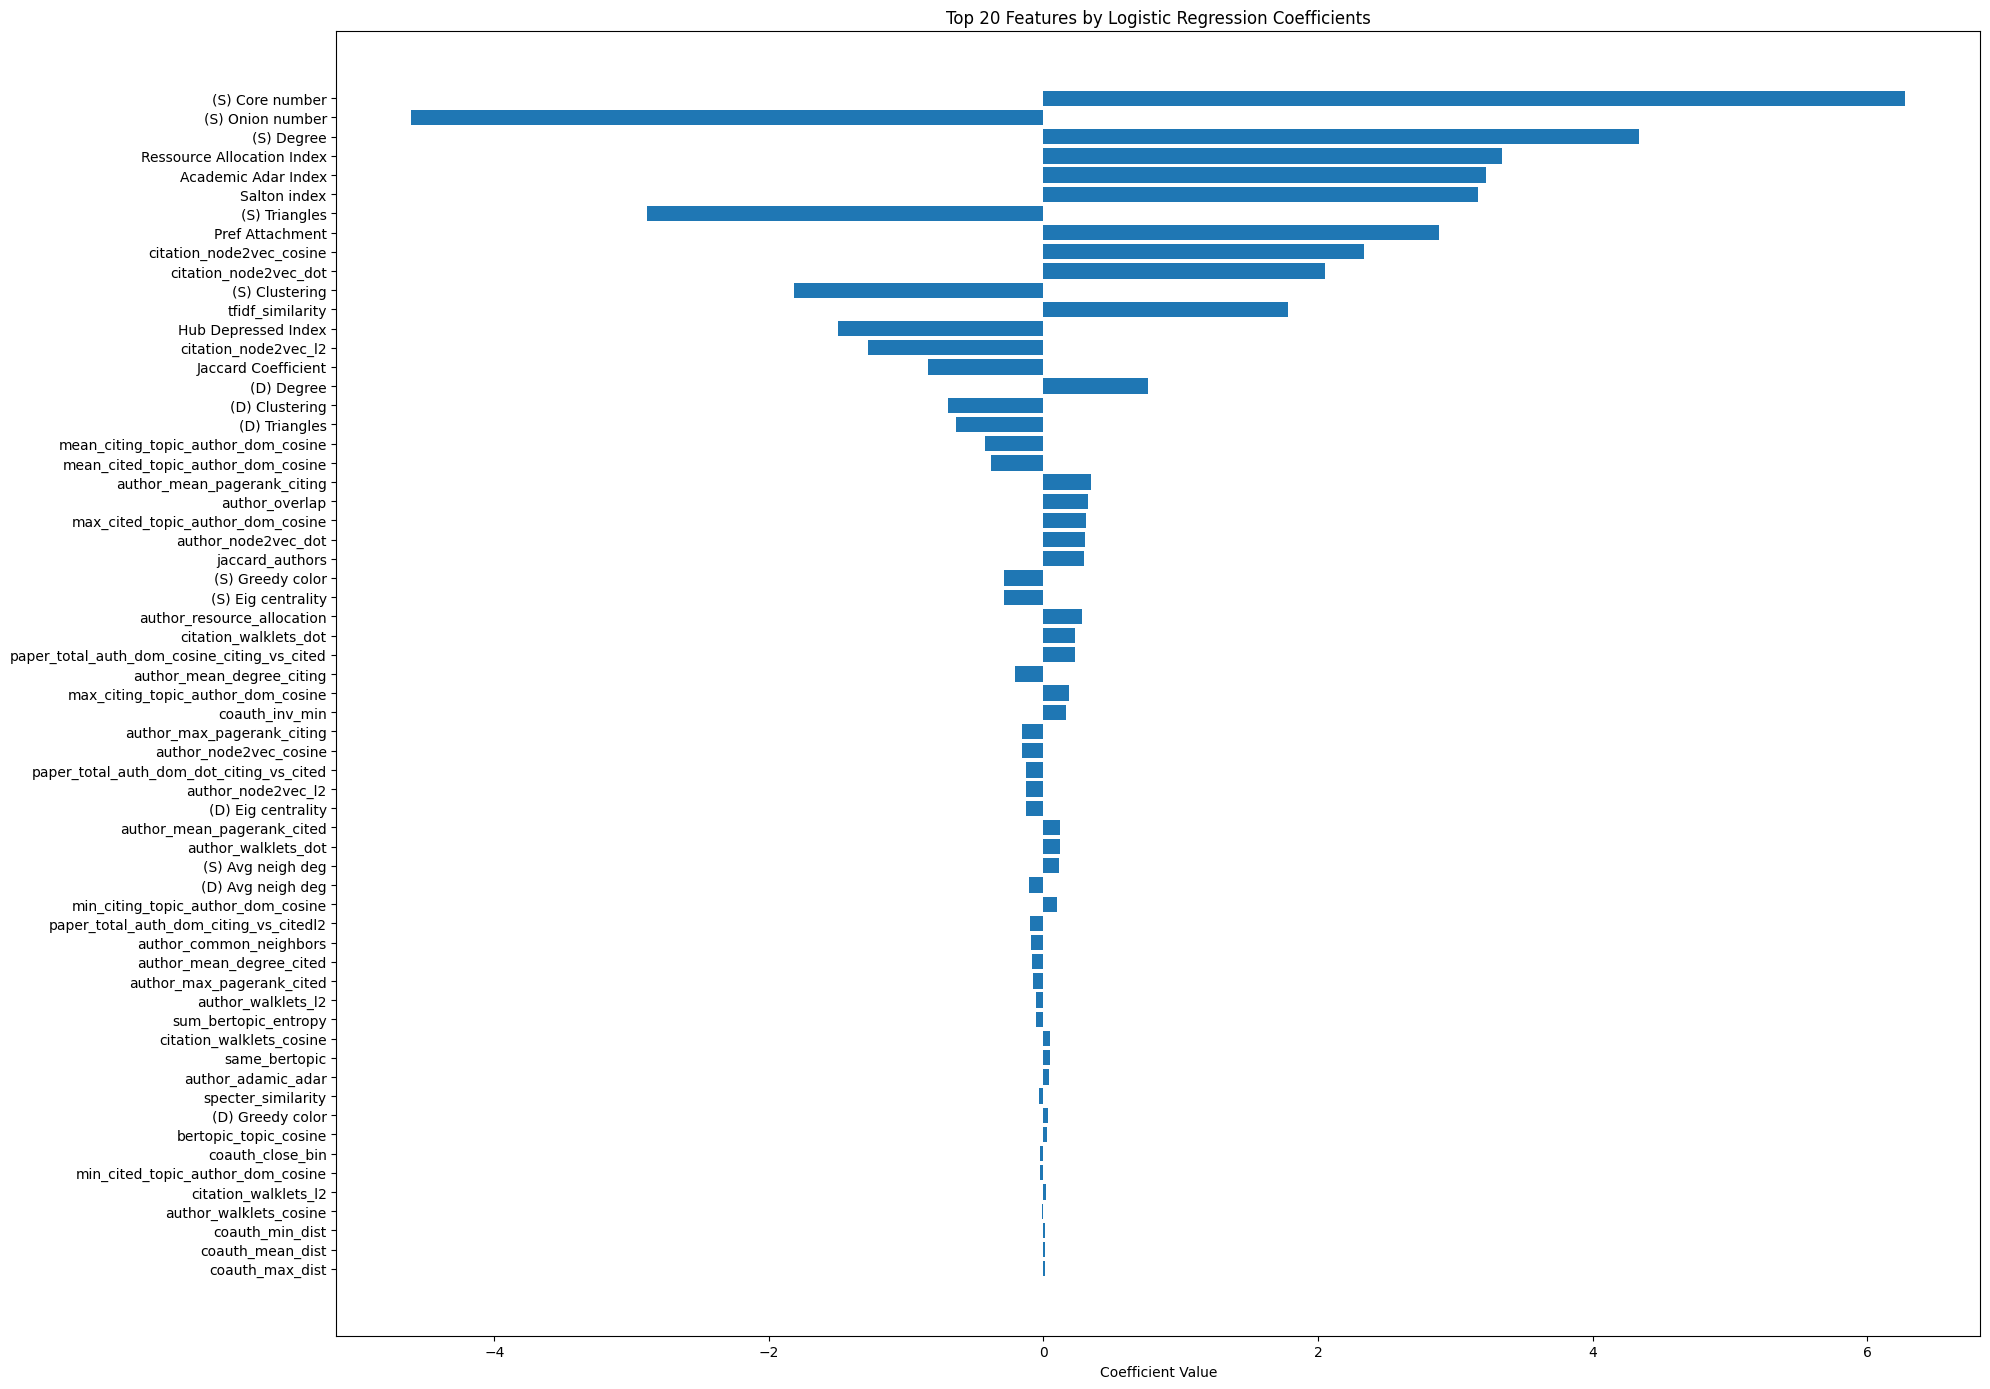

In [38]:
# 4. Εξαγωγή συσχετίσεων (coefficients)
coefs = lr_pipe.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({
    "feature": numeric_feats,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()
top20 = coef_df.sort_values("abs_coef", ascending=False)

# 5. Visualization
plt.figure(figsize=(20, 14))
plt.barh(top20["feature"][::-1], top20["coef"][::-1])
plt.xlabel("Coefficient Value")
plt.title("Top 20 Features by Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

In [12]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# 1. Φόρτωση train/val δεδομένων
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split", "Shortest Path"]
X = df.drop(columns=meta_cols)

# Διαχωρισμός σε train και validation
train_mask = df["split"] == "train"
val_mask = df["split"] == "val"
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]


# --- Preprocessor (όπως πριν) ---
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)

print("MLP")
# === 3. MLP με περισσότερα epochs ===
mlp_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(100,50),
        max_iter=500,               # ← μέχρι 500 epochs
        early_stopping=True,
        n_iter_no_change=10,        # ← early stop αν δεν βελτιωθεί για 20 epochs
        validation_fraction=0.1,
        tol=1e-4,
        verbose = 10,
    ))
])

mlp_pipe.fit(X_train, y_train)

print("=== MLPClassifier ===")
#mlp_pipe.fit(X_train, y_train)
y_pred_mlp  = mlp_pipe.predict(X_val)
y_proba_mlp = mlp_pipe.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_mlp, digits=4))
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_mlp):.4f}")
print(f"Log Loss: {log_loss(y_val, y_proba_mlp):.4f}")

MLP
Iteration 1, loss = 0.03592951
Validation score: 0.990048
Iteration 2, loss = 0.02950876
Validation score: 0.990578
Iteration 3, loss = 0.02827476
Validation score: 0.990837
Iteration 4, loss = 0.02744098
Validation score: 0.990985
Iteration 5, loss = 0.02692250
Validation score: 0.991107
Iteration 6, loss = 0.02640189
Validation score: 0.990918
Iteration 7, loss = 0.02602678
Validation score: 0.990888
Iteration 8, loss = 0.02568118
Validation score: 0.991397
Iteration 9, loss = 0.02539985
Validation score: 0.991427
Iteration 10, loss = 0.02519534
Validation score: 0.991488
Iteration 11, loss = 0.02504402
Validation score: 0.991244
Iteration 12, loss = 0.02481943
Validation score: 0.991346
Iteration 13, loss = 0.02460831
Validation score: 0.991346
Iteration 14, loss = 0.02451118
Validation score: 0.991463
Iteration 15, loss = 0.02435507
Validation score: 0.991529
Iteration 16, loss = 0.02424227
Validation score: 0.991605
Iteration 17, loss = 0.02406546
Validation score: 0.991422
It

In [15]:
# Μετά το model.fit(...)
booster = model.get_booster()

# Παίρνουμε το gain για κάθε feature
gain_dict = booster.get_score(importance_type='gain')

# Μετατρέπουμε σε DataFrame για εύκολη προβολή/ταξινόμηση
import pandas as pd

gain_df = (
    pd.DataFrame.from_dict(gain_dict, orient='index', columns=['gain'])
      .reset_index()
      .rename(columns={'index':'feature'})
      .sort_values('gain', ascending=False)
)

# Εκτύπωση των τοπ 20 πιο επιδραστικών features
print(gain_df.head(20))


NameError: name 'model' is not defined

In [34]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# 1. Φόρτωση δεδομένων
df = pd.read_parquet("D:/NLP/tfidf_xgboost/data_full.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split"]
X = df.drop(columns=meta_cols)

# 2. Διαχωρισμός train/val
train_mask = df["split"] == "train"
X_train, y_train = X[train_mask], y[train_mask]

# 3. Προεπεξεργασία και Logistic Regression
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=2000, tol=1e-4, n_jobs=-1))
])
lr_pipe.fit(X_train, y_train)

# 4. Εξαγωγή συσχετίσεων (coefficients)
coefs = lr_pipe.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({
    "feature": numeric_feats,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()
top20 = coef_df.sort_values("abs_coef", ascending=False)

# 5. Visualization
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"][::-1], top20["coef"][::-1])
plt.xlabel("Coefficient Value")
plt.title("Top 20 Features by Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [36]:
# 4. Εξαγωγή συσχετίσεων (coefficients)
coefs = lr_pipe.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({
    "feature": numeric_feats,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()
top20 = coef_df.sort_values("abs_coef", ascending=False)

# 5. Visualization
plt.figure(figsize=(20, 14))
plt.barh(top20["feature"][::-1], top20["coef"][::-1])
plt.xlabel("Coefficient Value")
plt.title("Top 20 Features by Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

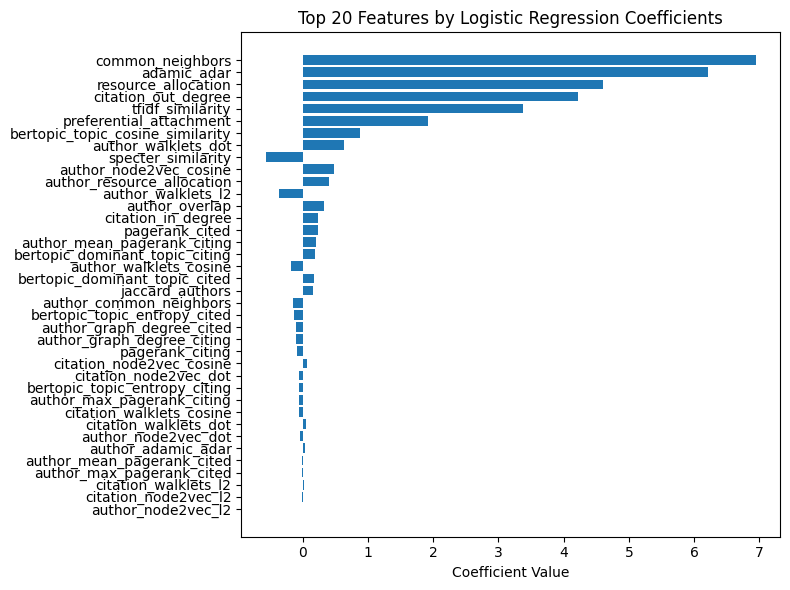

In [25]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# 1. Φόρτωση δεδομένων
df = pd.read_parquet(r"D:\NLP\tfidf_xgboost\split_train_val\scalar_features_train_val.parquet")
y = df["label"]
meta_cols = ["citing", "cited", "label", "split"]
X = df.drop(columns=meta_cols)

# 2. Διαχωρισμός train/val
train_mask = df["split"] == "train"
X_train, y_train = X[train_mask], y[train_mask]

# 3. Προεπεξεργασία και Logistic Regression
numeric_feats = X.columns.tolist()
preprocessor = ColumnTransformer(
    [("num", StandardScaler(), numeric_feats)],
    remainder="drop"
)
lr_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=2000, tol=1e-4, n_jobs=-1))
])
lr_pipe.fit(X_train, y_train)

# 4. Εξαγωγή συσχετίσεων (coefficients)
coefs = lr_pipe.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({
    "feature": numeric_feats,
    "coef": coefs
})
coef_df["abs_coef"] = coef_df["coef"].abs()
top20 = coef_df.sort_values("abs_coef", ascending=False)

# 5. Visualization
plt.figure(figsize=(8, 6))
plt.barh(top20["feature"][::-1], top20["coef"][::-1])
plt.xlabel("Coefficient Value")
plt.title("Top 20 Features by Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


In [44]:
from sklearn.ensemble import RandomForestClassifier

# === 2. Random Forest ===
print("Random Forest")

rf_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,       # π.χ. 200 δέντρα
        max_depth=None,         # άπειρο βάθος (ή βάλ’το σε 10–20 για regularization)
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42,
        verbose=10
    ))
])

# Εκπαίδευση
rf_pipe.fit(X_train, y_train)

# Προβλέψεις
y_pred_rf  = rf_pipe.predict(X_val)
y_proba_rf = rf_pipe.predict_proba(X_val)[:, 1]

# Αξιολόγηση
print("=== Random Forest ===")
print(classification_report(y_val, y_pred_rf, digits=4))
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_rf):.4f}")
print(f"Log Loss: {log_loss(y_val, y_proba_rf):.4f}")


Random Forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.6s


building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min


building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min


building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min


building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min


building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min


building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min


building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.5min


building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.3min


building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.3min


building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.3min


building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.7min


building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.0min


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 12.3min


building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.6min


building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.8713    0.9883    0.9261    109196
           1     0.9865    0.8540    0.9155    109195

    accuracy                         0.9212    218391
   macro avg     0.9289    0.9212    0.9208    218391
weighted avg     0.9289    0.9212    0.9208    218391

ROC AUC: 0.9890
Log Loss: 0.2814


In [45]:
# Υποθέτουμε rf_pipe από το προηγούμενο παράδειγμα ήδη έχει fit(X_train, y_train)

# 1. Βγάλε τα importances
importances = rf_pipe.named_steps['clf'].feature_importances_

# 2. Σύνδεσέ τα με τα ονόματα των features
feature_names = numeric_feats  # όπως τα είχες ορίσει στο preprocessor
feat_imp = list(zip(feature_names, importances))

# 3. Ταξινόμηση σε φθίνουσα σειρά
feat_imp_sorted = sorted(feat_imp, key=lambda x: x[1], reverse=True)

# 4. Εμφάνισε τα top 20
for name, score in feat_imp_sorted[:20]:
    print(f"{name:30s} → {score:.4f}")


citation_node2vec_cosine       → 0.1647
Hub Depressed Index            → 0.0851
Jaccard Coefficient            → 0.0756
specter_similarity             → 0.0722
Pref Attachment                → 0.0696
Ressource Allocation Index     → 0.0686
citation_node2vec_dot          → 0.0631
Academic Adar Index            → 0.0606
Salton index                   → 0.0588
tfidf_similarity               → 0.0587
(S) Degree                     → 0.0246
citation_node2vec_l2           → 0.0210
bertopic_topic_cosine          → 0.0172
paper_total_auth_dom_cosine_citing_vs_cited → 0.0171
(S) Avg neigh deg              → 0.0148
(S) Triangles                  → 0.0140
(S) Clustering                 → 0.0104
max_citing_topic_author_dom_cosine → 0.0094
mean_citing_topic_author_dom_cosine → 0.0093
max_cited_topic_author_dom_cosine → 0.0082


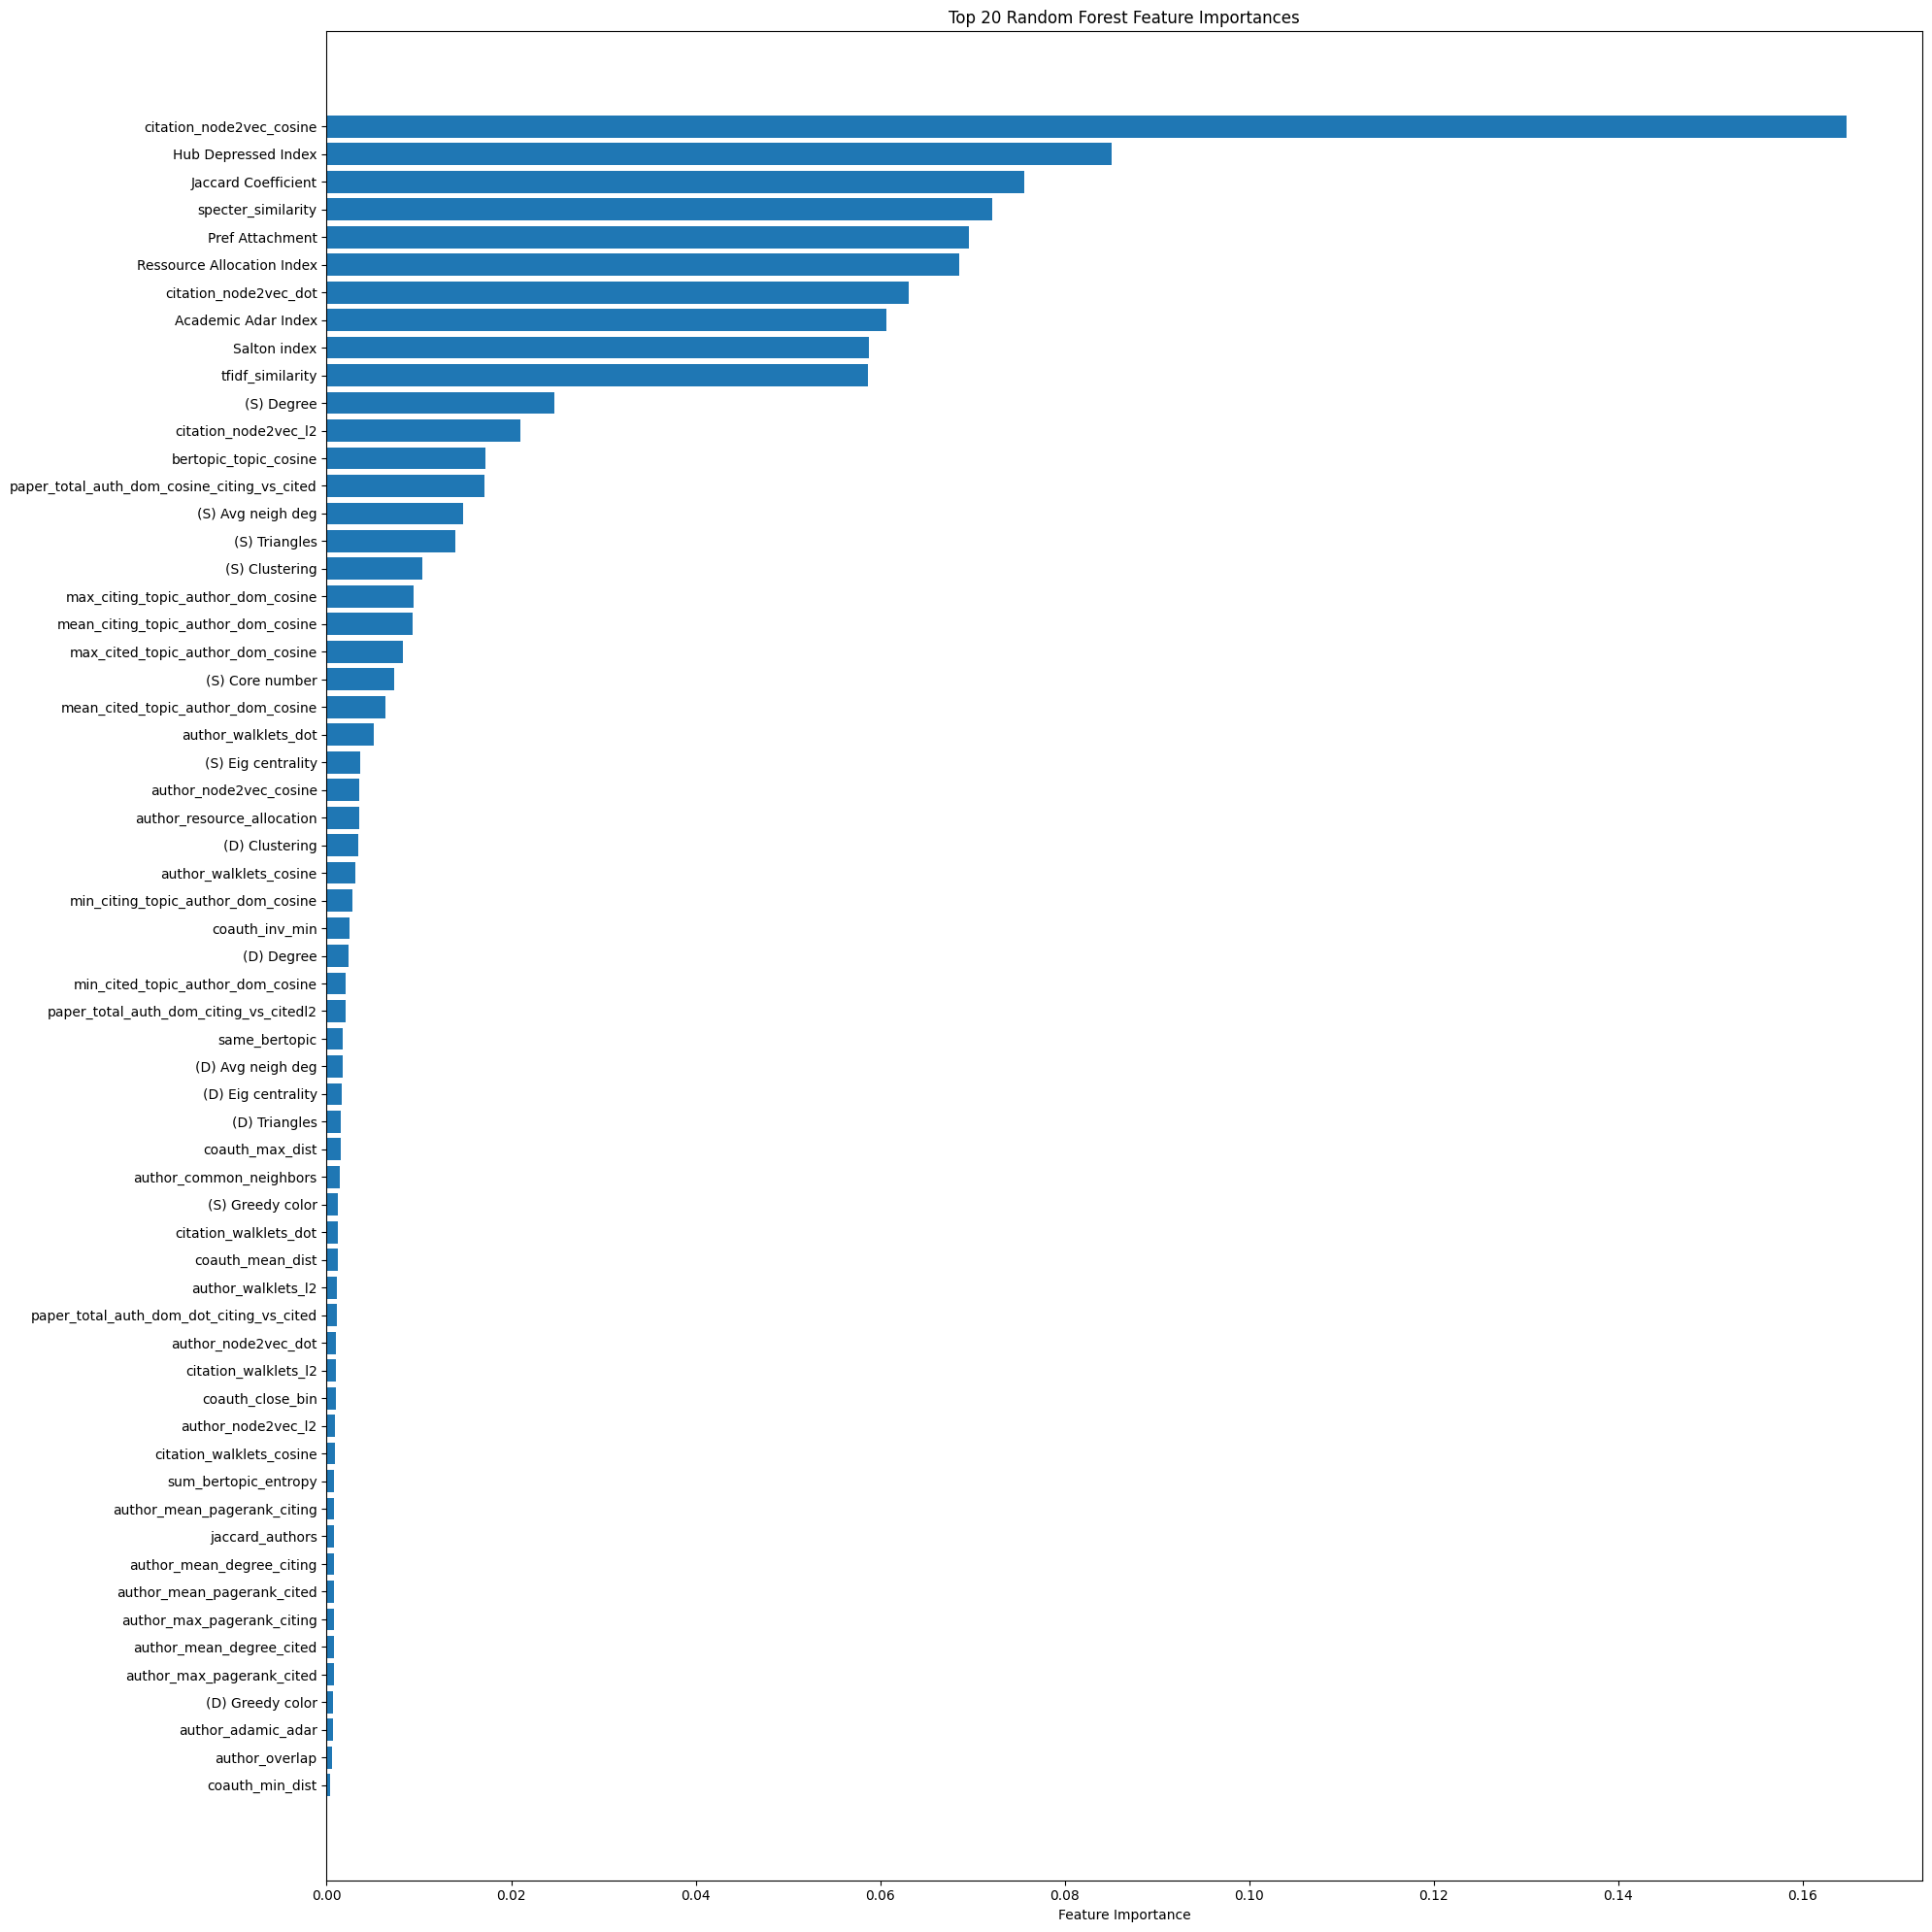

In [53]:
import matplotlib.pyplot as plt

# Top 20
top20 = feat_imp_sorted
names = [n for n,_ in top20]
scores = [s for _,s in top20]

plt.figure(figsize=(20,20))
plt.barh(names[::-1], scores[::-1])  # ανάποδη σειρά ώστε το μεγαλύτερο πάνω
plt.xlabel("Feature Importance")
plt.title("Top 20 Random Forest Feature Importances")
plt.tight_layout()
plt.show()
